In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torch import nn

from sklearn.preprocessing import StandardScaler

from itertools import product
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

import plotly.express as px
from pyproj import Transformer

import os
import joblib

import importlib
import json
import itertools

In [2]:
def visualize_trajectories(df, color_by='MMSI', title=None, zoom=5, height=800):
    
    transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(df['UTM_x'].values, df['UTM_y'].values)
    
    if 'Trajectory' in df.columns:
        vis_cols = ['Trajectory', 'MMSI', 'Timestamp', 'UTM_x', 'UTM_y']
    else:
        vis_cols = ['MMSI', 'Timestamp', 'UTM_x', 'UTM_y']

    if color_by not in vis_cols:
        vis_cols.append(color_by)

    if 'SOG' in df.columns and 'SOG' not in vis_cols:
        vis_cols.append('SOG')
    
    vis_df = df[vis_cols].copy()
    vis_df['Longitude'] = lon
    vis_df['Latitude'] = lat
    
    # Generate title if not provided
    if title is None:
        date_min = vis_df['Timestamp'].min().date()
        date_max = vis_df['Timestamp'].max().date()
        title = f"Ship Trajectories - {date_min} to {date_max}"
    
    # Create visualization with trajectories using lat/lon on a map
    fig = px.line_map(
        vis_df.sort_values('Timestamp'),
        lat="Latitude",
        lon="Longitude",
        color=color_by,
        hover_data=["MMSI", "Timestamp", "SOG"] if "SOG" in vis_df.columns else ["MMSI", "Timestamp"],
        zoom=zoom,
        title=title
    )
    
    fig.update_layout(
        mapbox_style="open-street-map",
        showlegend=False,  # Hide legend since there can be many trajectories
        height=height
    )
    
    print(f"✓ Visualization complete - colored by '{color_by}'")
    
    return fig

In [3]:
# Define params
TR_DATA_DIR = 'data/aisdk/train/aisdk_2025'
TE_DATA_DIR = 'data/aisdk/test/aisdk_2025'
V_DATA_DIR  = 'data/aisdk/val/aisdk_2025'
MODEL_DIR   = 'checkpoints' 

# 3. Clustering Vessel Behaviours

## 3.1 Recurrent AutoEncoder
To cluster vessel behaviours, we first learn a compact representation of each trajectory. We use a Recurrent AutoEncoder (RAE), where a GRU encoder reads the full trajectory and compresses it into a latent vector. A GRU decoder then tries to reconstruct the original sequence from this vector. After training, we keep only the encoder and use its latent vectors as the input to the clustering step. The idea is that similar motion patterns should produce similar latent representations.


In this notebook, we load a pre-trained RAE model. The complete training procedure is documented in **`models/train_RAE.ipynb`**.

In [4]:
from src.models import RAE
importlib.reload(RAE)
from src.visualization.visualize_rae import visualize_rae_latent_space

In [5]:
class TrajectoryDataset(Dataset):
    def __init__(self, trajectories):
        self.trajectories = trajectories
    
    def __len__(self):
        return len(self.trajectories)
    
    def __getitem__(self, idx):
        traj = torch.FloatTensor(self.trajectories[idx])
        return traj

In [6]:
def pad_trajectories(batch):
    lengths = torch.tensor([len(traj) for traj in batch])
    padded = pad_sequence(batch, batch_first=True, padding_value=0.0)

    lengths, perm_idx = lengths.sort(descending=True)
    padded = padded[perm_idx]

    return padded, lengths

In [7]:
# Start with loading the data
train = pd.read_parquet(TR_DATA_DIR)
val = pd.read_parquet(V_DATA_DIR)

# Turn train and val sets into lists of trajectories
train_trajectories = []
    
for traj_id in train['Trajectory'].unique():
    traj_data = train[train['Trajectory'] == traj_id].sort_values('Timestamp')
    features = traj_data[['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']].values
    train_trajectories.append(features)

print(f"Total trajectories: {len(train_trajectories)}")

val_trajectories = []
    
for traj_id in val['Trajectory'].unique():
    traj_data = val[val['Trajectory'] == traj_id].sort_values('Timestamp')
    features = traj_data[['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']].values
    val_trajectories.append(features)

print(f"Total trajectories: {len(val_trajectories)}")

Total trajectories: 777
Total trajectories: 167


In [8]:
train_dataset = TrajectoryDataset(train_trajectories)
val_dataset = TrajectoryDataset(val_trajectories)


In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [13]:
# Load the trained model
checkpoint = torch.load(os.path.join(MODEL_DIR, 'rae', 'best_rae_model.pth'))

# Get hyperparameters 
hp = checkpoint['hyperparameters']

model = RAE.RecurrentAutoencoder(
    input_dim=hp['feature_size'],
    hidden_dim=hp['hidden_size'],
    latent_dim=hp['latent_dim'],
    num_layers_encoder=hp['encoder_layers'],
    num_layers_decoder=hp['decoder_layers'],
    dropout=hp['dropout']
).to(device)


# Load the trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

print(f"Model loaded! Best val_loss: {checkpoint['val_loss']}")
print(f"Trained for {checkpoint['epoch']} epochs")

Model loaded! Best val_loss: 1.5638
Trained for 30 epochs


Collected 167 samples for visualization


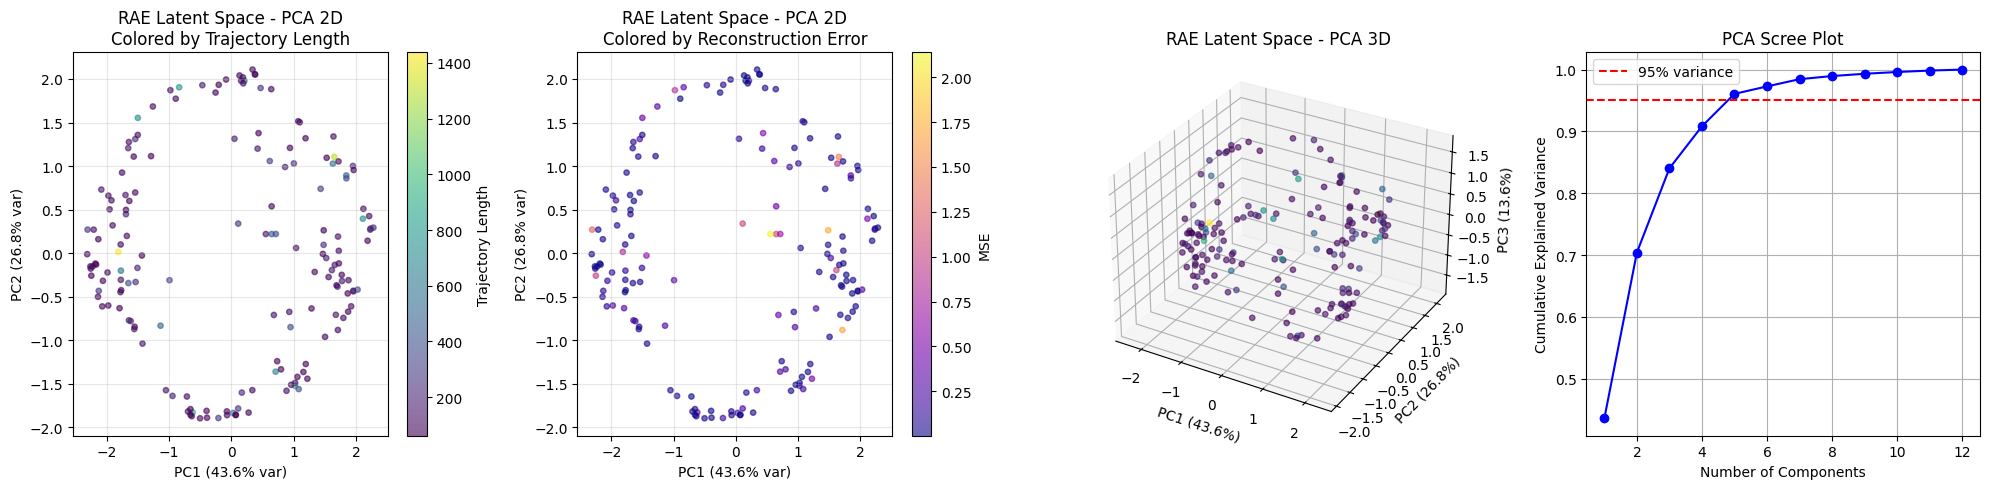

Computing t-SNE... (this may take a minute)


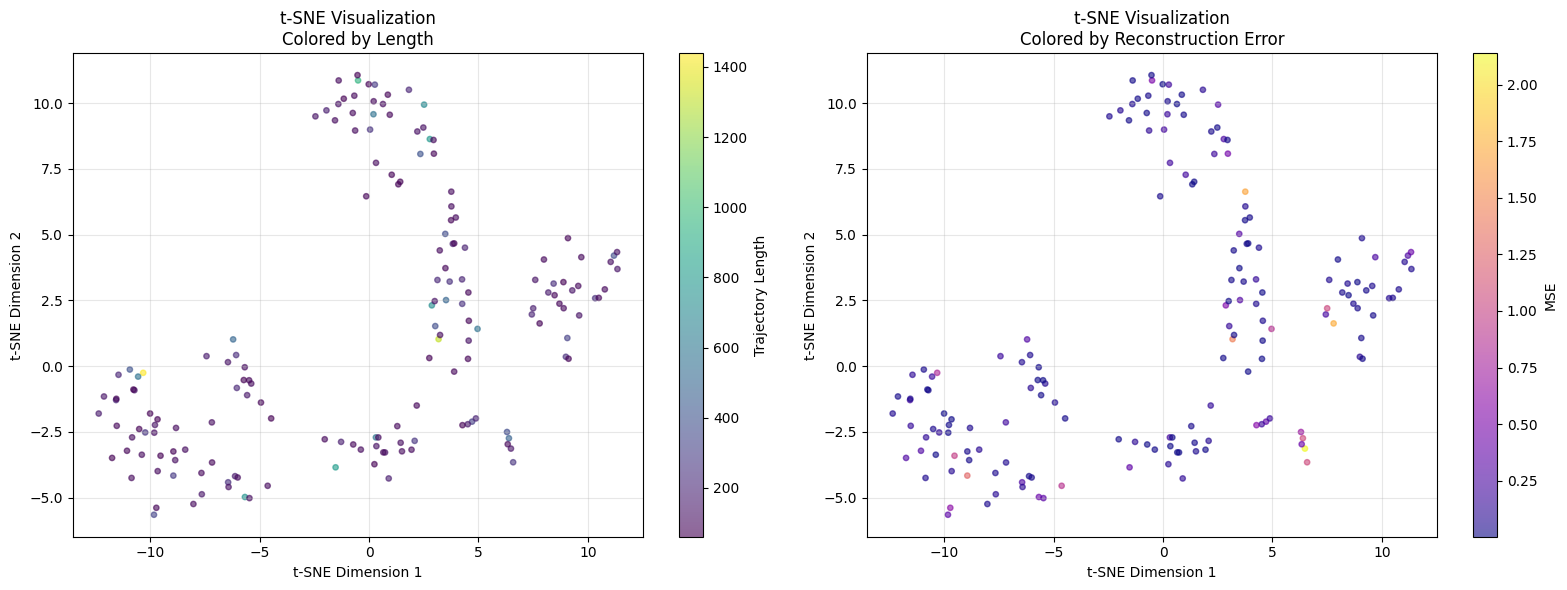

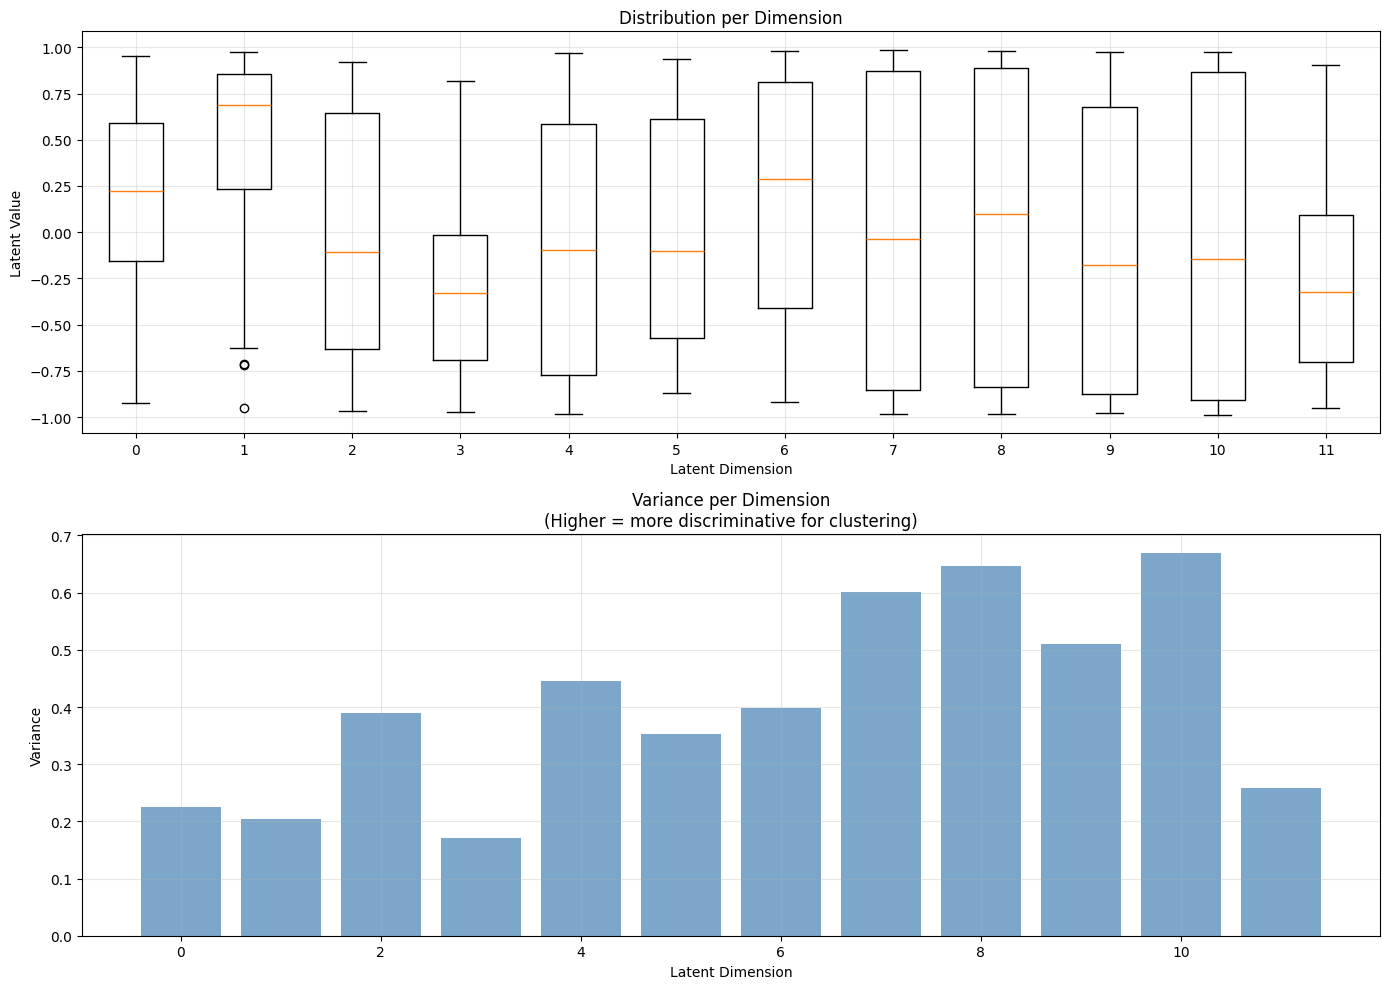

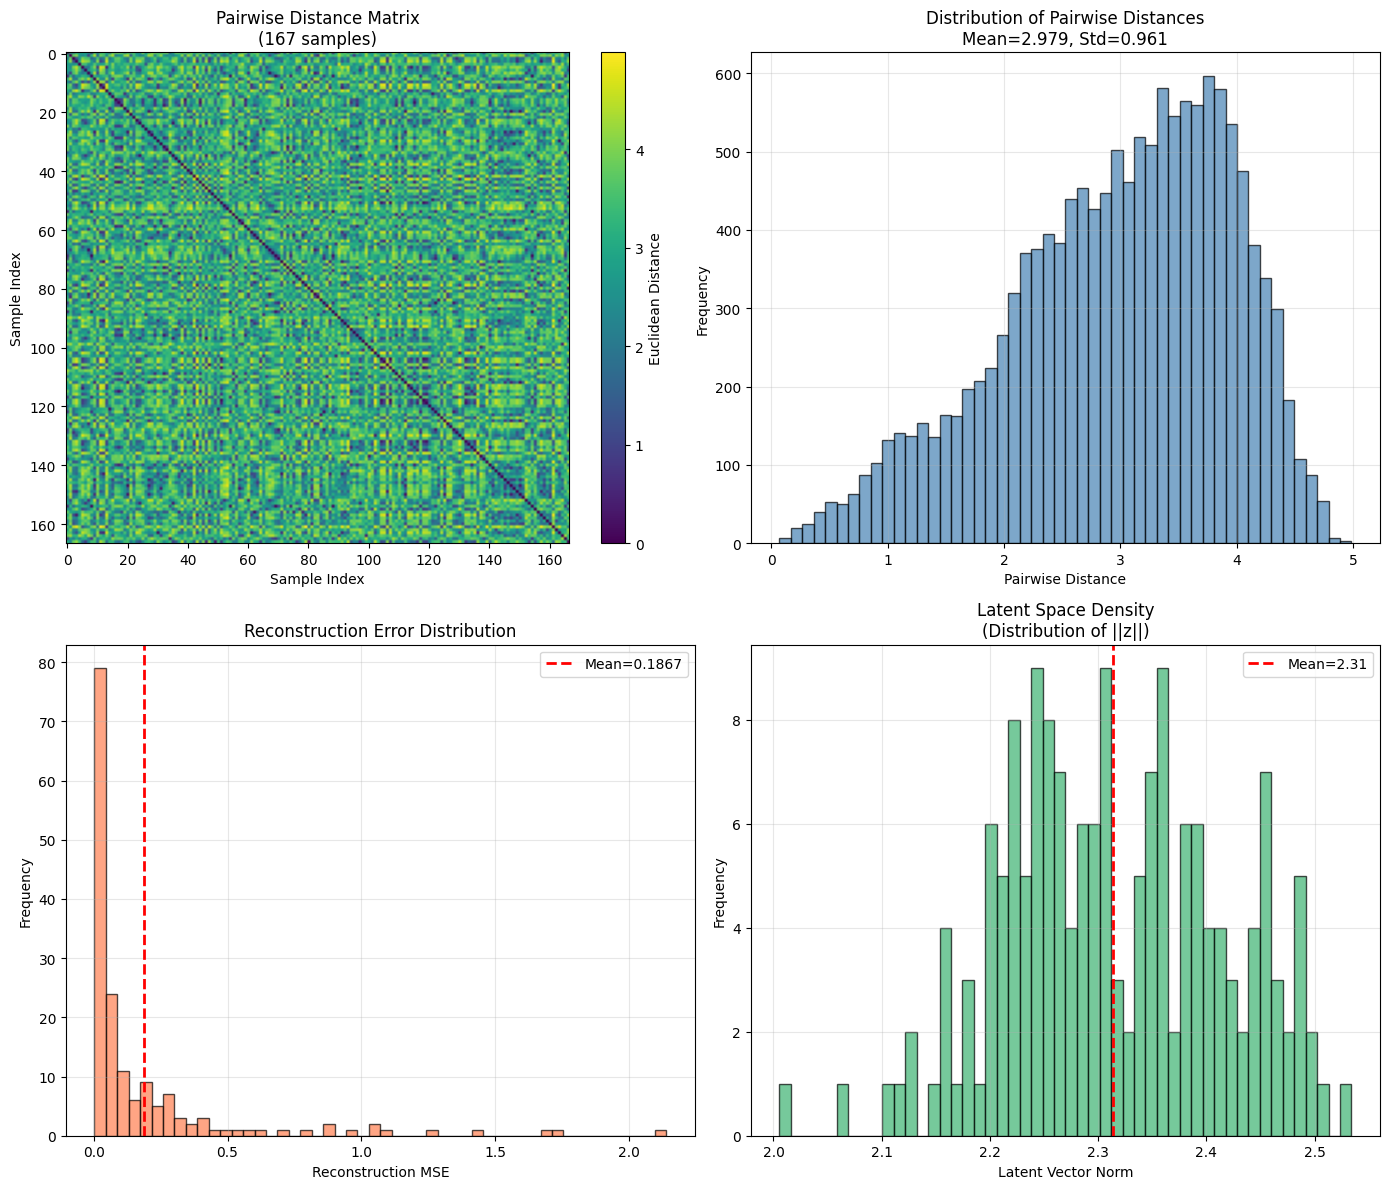

Generating reconstruction examples...


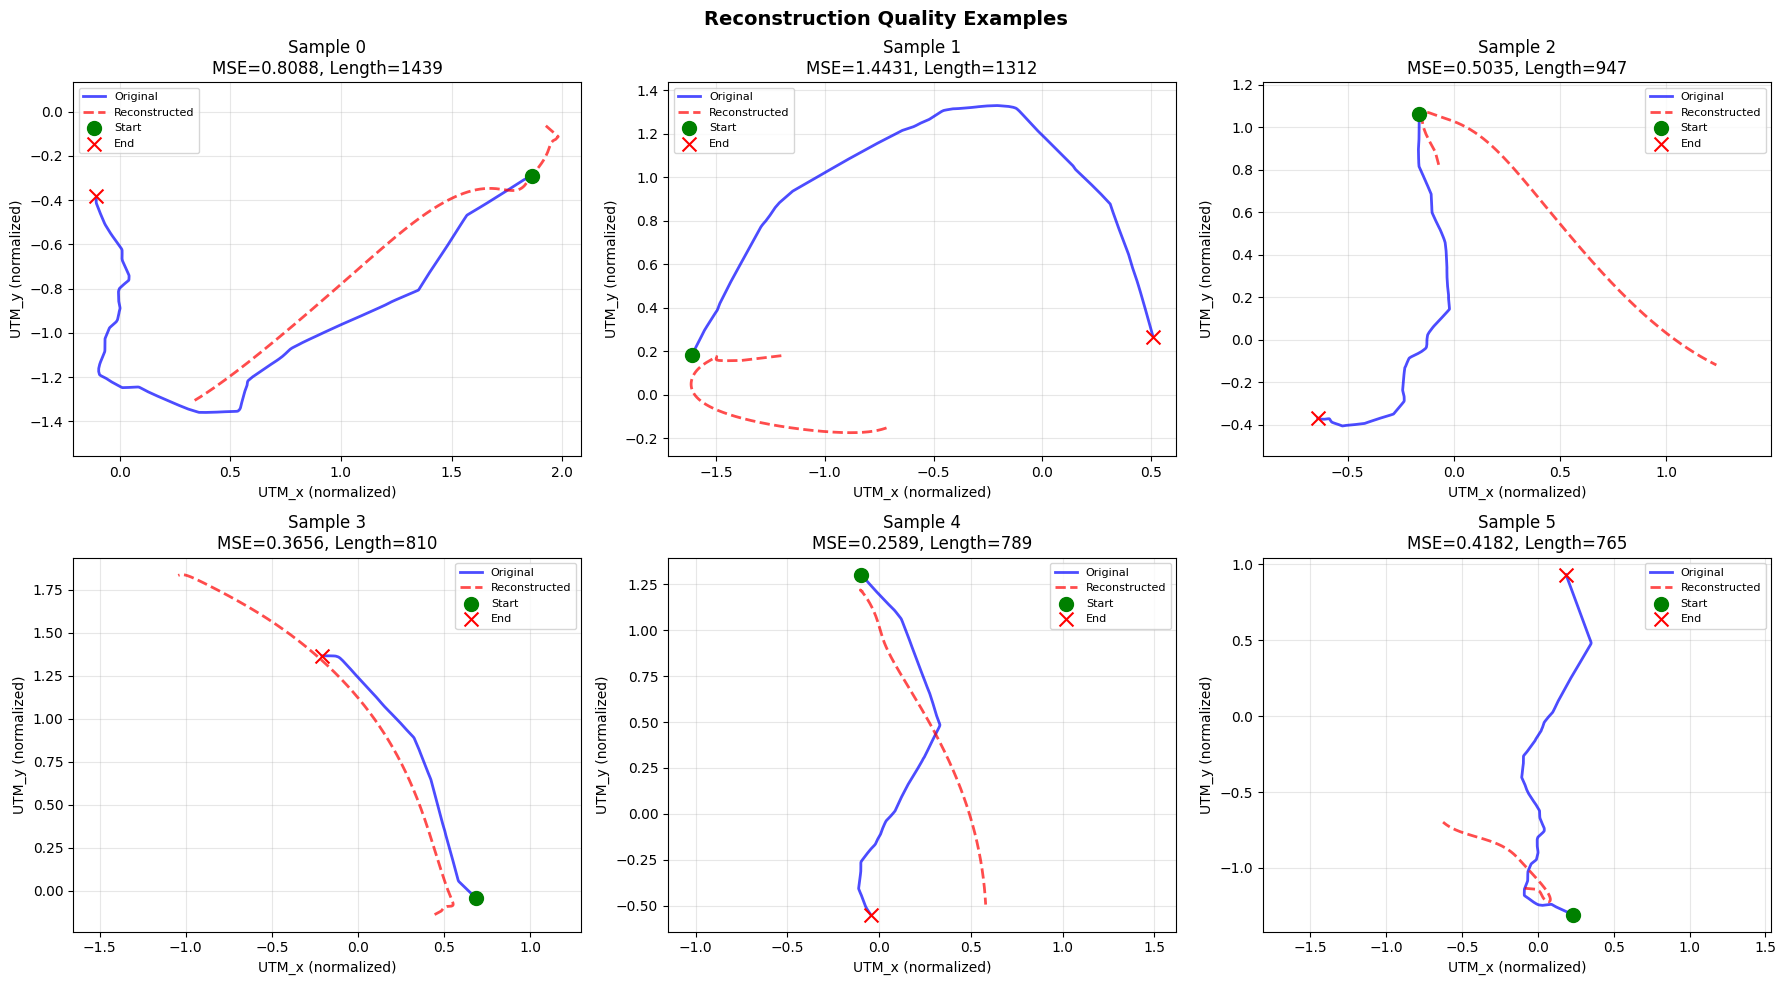

Running K-means clustering preview...


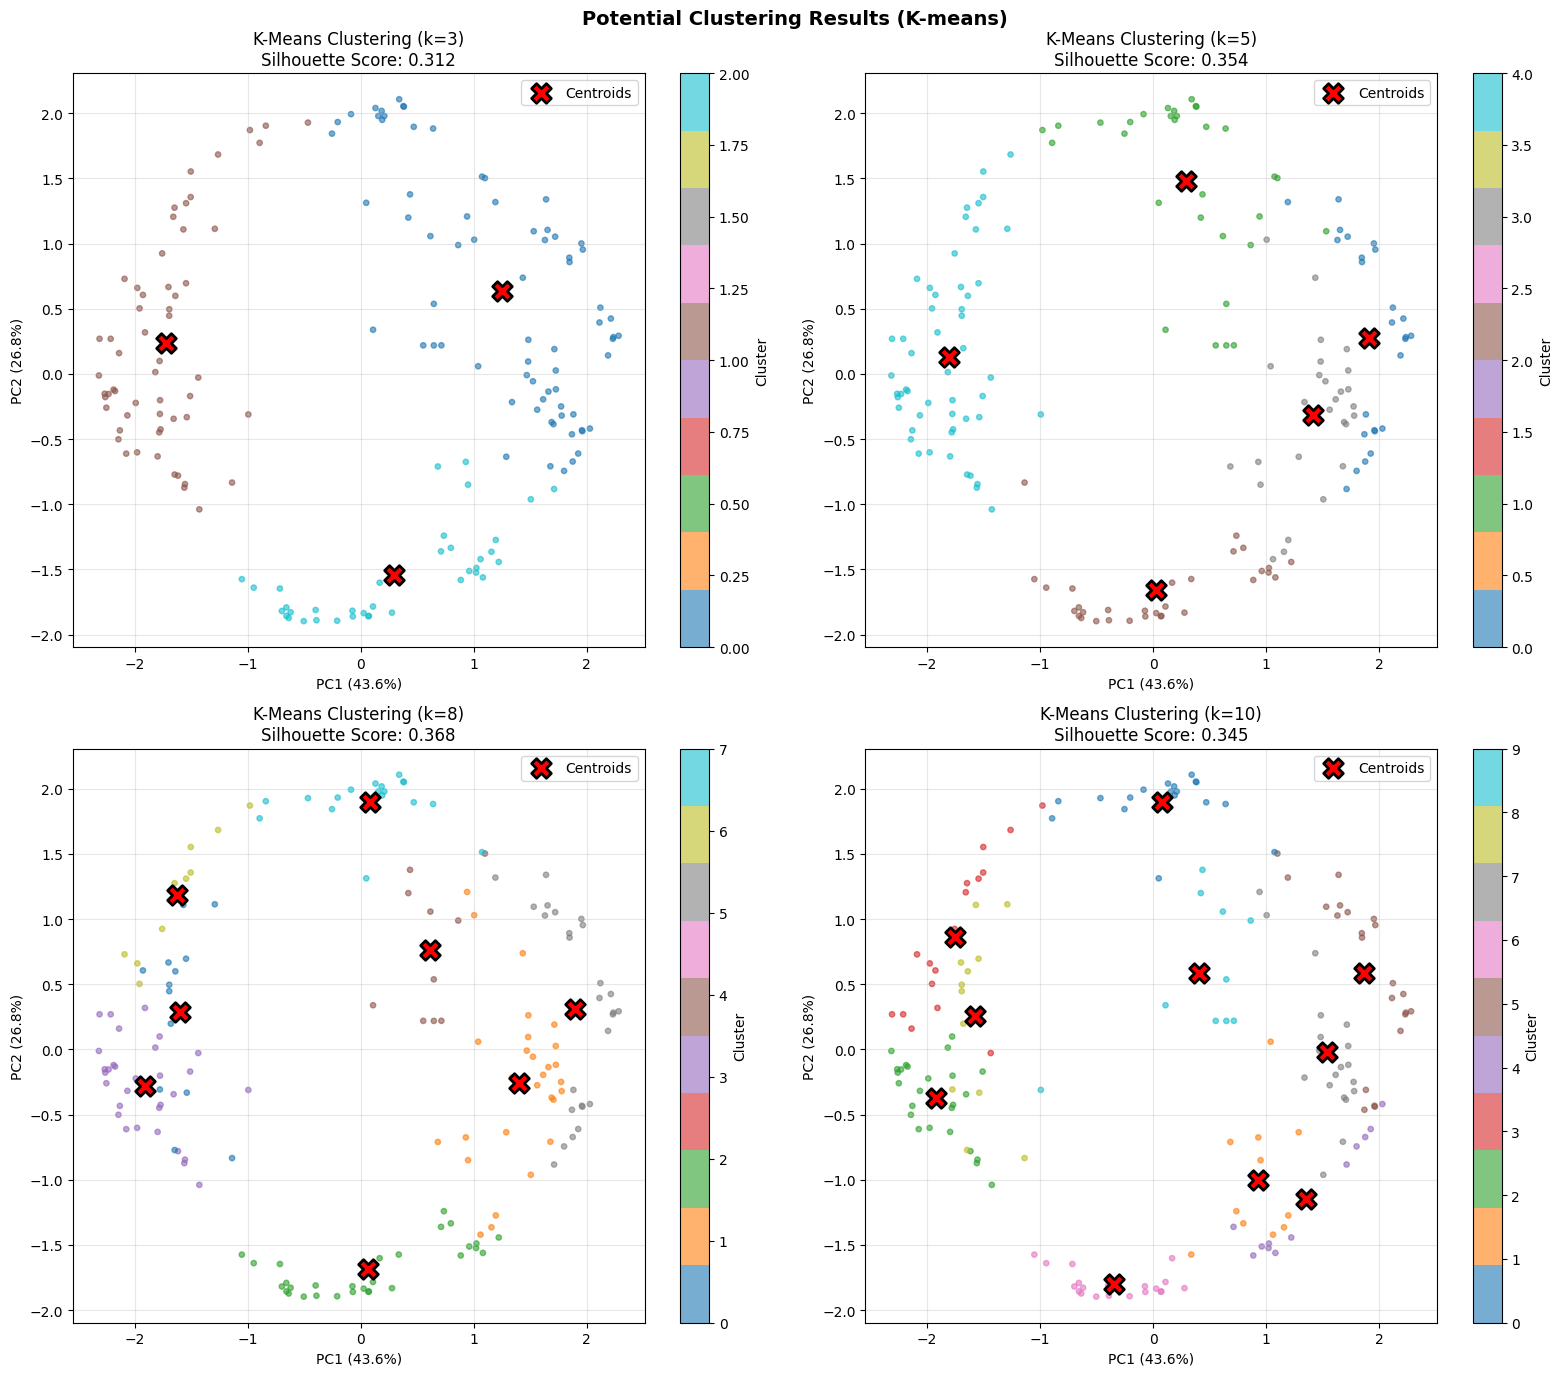


RAE LATENT SPACE ANALYSIS SUMMARY

📊 Dataset Statistics:
  Total samples: 167
  Latent dimensions: 12
  Avg trajectory length: 188.4 ± 209.2

🎯 Latent Space Statistics:
  Mean: 0.0062
  Std:  0.6685
  Norm (mean): 2.3137
  Norm (std):  0.1016

📈 Reconstruction Quality:
  Mean MSE: 0.186716
  Std MSE:  0.340856
  Min MSE:  0.002443
  Max MSE:  2.139418

🔍 Clustering Indicators:
  Mean pairwise distance: 2.9793
  Std pairwise distance:  0.9614
  Variance per dim (mean): 0.4059
  Variance per dim (std):  0.1663
  PCA 95% variance: 5 components
  Active dimensions: 12/12 (100.0%)

🏥 Health Assessment:
  ✅ Overall std > 0.3: Good spread
  ⚠️  High reconstruction error: May need more training
  ✅ Good separation between samples
  ✅ 100% dimensions active: Good capacity usage
  ✅ Good variance: Suitable for clustering

📊 Overall Health Score: 4/5
  🎉 EXCELLENT - Ready for clustering!

✅ All visualizations saved to 'rae_visualizations/'


In [22]:
# Create a visualization loader
viz_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=pad_trajectories
)

# Run RAE visualization
rae_results = visualize_rae_latent_space(
    model=model,  # Your trained RAE model
    data_loader=viz_loader,
    device=device,
    save_dir='rae_visualizations',
    max_samples=5000
)

# Access results
latents = rae_results['latents']
health_score = rae_results['health_score']
pca_transform = rae_results['pca_2d']

## 3.2 HDBSCAN
After extracting a latent vector for each trajectory, we cluster these vectors using HDBSCAN. The training procedure is shown in the notebook `models/train_hdbscan.ipynb`, where HDBSCAN is fitted to the latent space and used to assign each trajectory to a cluster. The resulting cluster labels are then saved under `data/aisdk/processed/clustered/...` for use in the classification and prediction stages.

<span style=color:red>ath make sure this is a accurate file path</span>

In [14]:
import hdbscan

In [17]:
encode_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=pad_trajectories
)

In [23]:
model.eval()
all_train_latents = []
with torch.no_grad():
    for batch, lengths in encode_loader:
        batch = batch.to(device)
        lengths = lengths.to(device)
        z = model.encode(batch, lengths)  # [batch_size, latent_dim]
        all_train_latents.append(z.cpu())

train_latents = torch.cat(all_train_latents, dim=0).numpy()  # shape: [N_trajectories, latent_dim]
print("Encoded train latents:", train_latents.shape)

Encoded train latents: (777, 12)


In [24]:
clusterer = hdbscan.HDBSCAN(
        min_cluster_size=30,   # TODO: Tune
        min_samples=None,      # TODO: Tune
        metric="euclidean",
        cluster_selection_method="eom",
    )

labels = clusterer.fit_predict(train_latents)

/Users/helgamariamagnusdottir/Documents/dtu/deep_learning/DL-group-63-P29/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/helgamariamagnusdottir/Documents/dtu/deep_learning/DL-group-63-P29/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


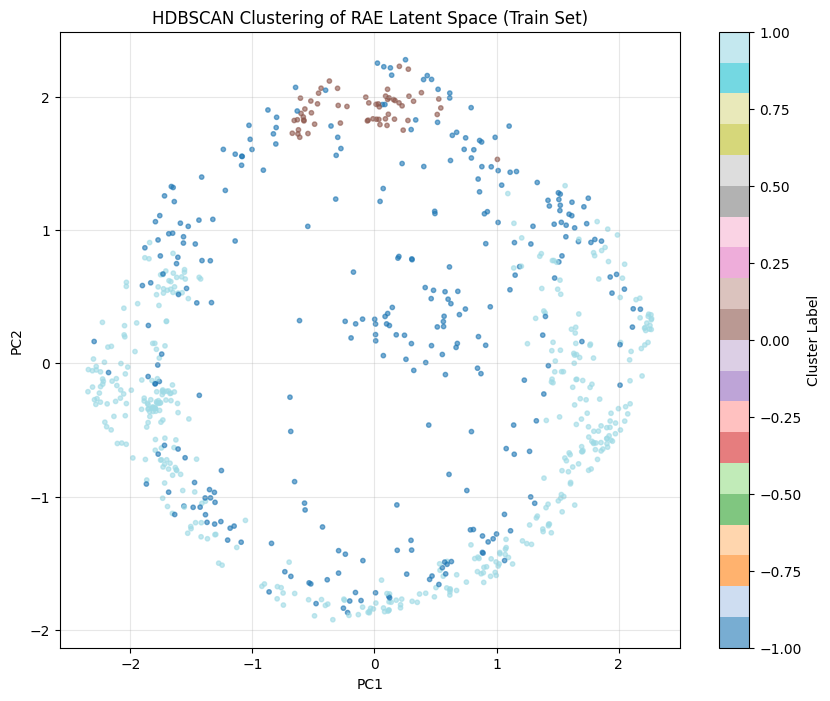

In [25]:
# Visualise clusters in PCA space
train_latents_pca = pca_transform.transform(train_latents)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    train_latents_pca[:, 0], 
    train_latents_pca[:, 1], 
    c=labels, 
    cmap='tab20', 
    alpha=0.6, 
    s=10
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('HDBSCAN Clustering of RAE Latent Space (Train Set)')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True, alpha=0.3)
plt.show()

TALK ABOUT THAT WE GOT 9 GROUPS XX....